## 1. Library and Package Installing

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

!pip install -U openpyxl

# # Don't do in production. Doing now to keep output clean for understanding
# import warnings
# warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are

## 2. Data Preprocessing

### 2.1 Data Import

In [17]:
import pandas as pd
df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")

print(df.describe(), df.shape)
df.head()

                 id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000 (20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### 2.2 Dataset Analysis

In [18]:
df.isnull().sum()

,0
id,0
title,558
author,1957
text,43
label,0


In [19]:
df1 = df.dropna()
df1.describe()

,id,label
count,18281.000000,18281.000000
mean,10409.499043,0.433237
std,5998.629214,0.495536
min,0.000000,0.000000
25%,5216.000000,0.000000
50%,10421.000000,0.000000
75%,15603.000000,1.000000
max,20799.000000,1.000000


In [20]:
df['label'].value_counts(), df1['label'].value_counts()

(label
 1    10413
 0    10387
 Name: count, dtype: int64,
 label
 0    10361
 1     7920
 Name: count, dtype: int64)

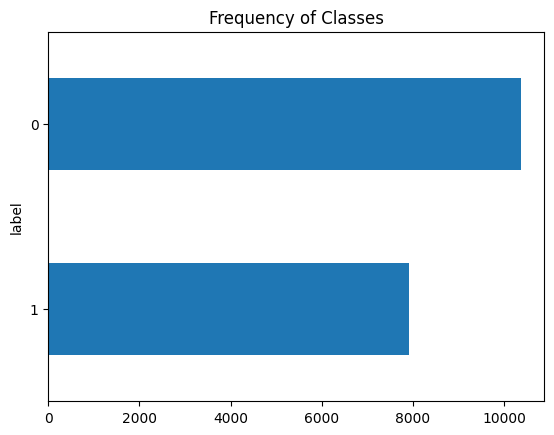

In [21]:
import matplotlib.pyplot as plt
label_counts = df1['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Frequency of Classes')
plt.show()

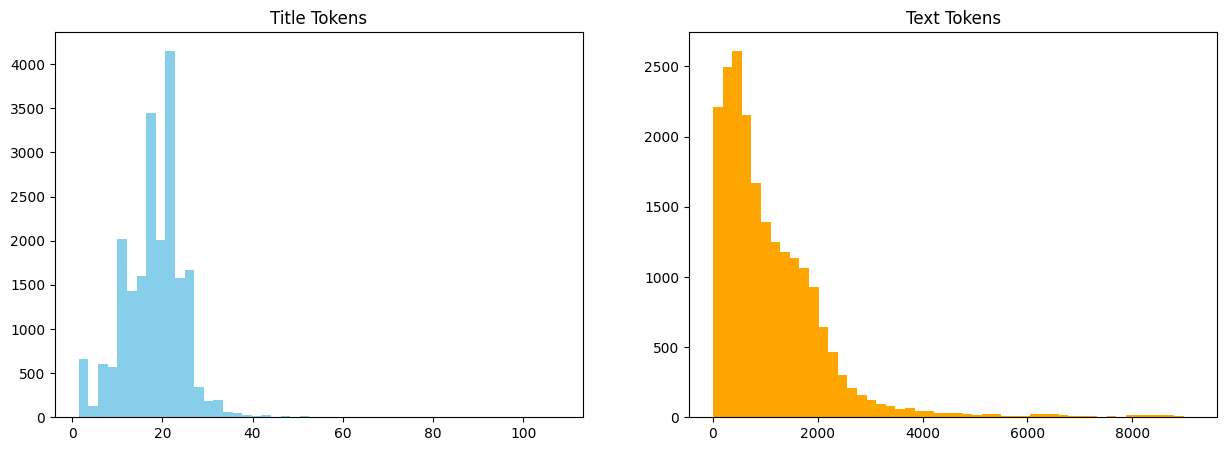

In [22]:
df['title_tokens'] = df['title'].apply(lambda x:len(str(x).split()) * 1.5)
df['text_tokens'] = df['text'].apply(lambda x:len(str(x).split()) * 1.5)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

### 2.3 Data Loader and Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size=0.3, stratify=df1['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df1.shape

((12796, 5), (3656, 5), (1829, 5), (18281, 5))

In [26]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    'train': Dataset.from_pandas(train, preserve_index=False),
    'test': Dataset.from_pandas(test, preserve_index=False),
    'validation': Dataset.from_pandas(validation, preserve_index=False)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label'],
        num_rows: 1829
    })
})

### 2.4 Data Tokenization

In [28]:
from transformers import AutoTokenizer

text = "CSGO is better than Valorant!"

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)

distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

In [30]:
def tokenize(batch):
  temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2182, 1005, 1055, 2115, 7848, 999, 18520, 15734, 23516, 22028, 1011, 15536, 3211, 19738, 5705, 102, 0, 0, 0, 0, 0, 0], [101, 1996, 12459, 3606, 2055, 2088, 2162, 1017, 1006, 2418, 5665, 12717, 19833, 2072, 2933, 1004, 20932, 1516, 3607, 2030, 7025, 1007, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [31]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## 3. Model Building

In [32]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"REAL": 0, "FAKE": 1}
id2label = {0: "REAL", 1: "FAKE"}

model_ckpt = "distilbert-base-uncased"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, num_labels=num_labels, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "REAL",
    "1": "FAKE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "FAKE": 1,
    "REAL": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.48.0",
  "vocab_size": 30522
}

In [37]:
# !pip install evaluate

In [38]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [41]:
from transformers import TrainingArguments
from transformers import Trainer

BATCH_SIZE=32
training_dir = 'train_dir'

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir = True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch'
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['validation'],
    compute_metrics = compute_metrics,
    tokenizer = distilbert_tokenizer
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-41-a8ba37087244>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.115128,0.954073
2,0.171000,0.119146,0.956807


TrainOutput(global_step=800, training_loss=0.14207135200500487, metrics={'train_runtime': 254.375, 'train_samples_per_second': 100.607, 'train_steps_per_second': 3.145, 'total_flos': 602538311802336.0, 'train_loss': 0.14207135200500487, 'epoch': 2.0})

## 4. Model Evaluation

In [42]:
preds_output = trainer.predict(encoded_dataset['test'])
preds_output.metrics

{'test_loss': 0.11053463816642761,
 'test_accuracy': 0.9576039387308534,
 'test_runtime': 10.0663,
 'test_samples_per_second': 363.191,
 'test_steps_per_second': 11.424}

In [43]:
y_pred = np.argmax(preds_output.predictions, axis=-1)
y_test = encoded_dataset['test']['label']

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2072
           1       0.95      0.95      0.95      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.96      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## BenchMarking

In [44]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [45]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics


import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  bert-base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

<ipython-input-45-67615d329237>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.251000
1000,0.199400
1500,0.157700
2000,0.104600
2500,0.090300
3000,0.087300
3500,0.055800
4000,0.021700
4500,0.045200





Training Model:  distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

<ipython-input-45-67615d329237>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.252100
1000,0.173200
1500,0.162600
2000,0.095300
2500,0.083200
3000,0.100000
3500,0.055600
4000,0.025000
4500,0.045900





Training Model:  mobilebert


pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

<ipython-input-45-67615d329237>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,42611.520000
1000,0.279100
1500,0.177200
2000,0.120400
2500,0.113900
3000,0.362200
3500,0.065900
4000,0.043600
4500,0.058700





Training Model:  tinybert


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

<ipython-input-45-67615d329237>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.300700
1000,0.213700
1500,0.198100
2000,0.140700
2500,0.141600
3000,0.155900
3500,0.102300
4000,0.084900
4500,0.101600


In [46]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.19906283915042877,
   'test_accuracy': 0.962253829321663,
   'test_f1': 0.9622883013603741,
   'test_runtime': 19.5463,
   'test_samples_per_second': 187.043,
   'test_steps_per_second': 23.38},
  'time taken': 1029.7146208286285},
 'distilbert': {'distilbert': {'test_loss': 0.1682099848985672,
   'test_accuracy': 0.962800875273523,
   'test_f1': 0.9628468639291917,
   'test_runtime': 10.129,
   'test_samples_per_second': 360.945,
   'test_steps_per_second': 45.118},
  'time taken': 677.7424376010895},
 'mobilebert': {'mobilebert': {'test_loss': 0.17855119705200195,
   'test_accuracy': 0.962800875273523,
   'test_f1': 0.9628170461473012,
   'test_runtime': 18.4213,
   'test_samples_per_second': 198.466,
   'test_steps_per_second': 24.808},
  'time taken': 890.103978395462},
 'tinybert': {'tinybert': {'test_loss': 0.19918876886367798,
   'test_accuracy': 0.9584245076586433,
   'test_f1': 0.9584182733647391,
   'test_runtime': 3.4344,
   'test_